In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [95]:
def TMCSample(v, w_hat, N, V,it_mcmc=100, ß=1):
    vtab = torch.zeros((v.shape[0], v.shape[1],it_mcmc+1))
    vtab[:,:,0] = v[:,:]
    v_curr = v
    V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        print(t)
        #start = time.time()
        h_curr, _ = myRBM.SampleHiddens01(v_curr.cuda())
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1))
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
    
        for idx in range(v_curr.shape[0]):
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)
            # tmp = torch.exp(ß*((2*v_next[i]-1)*h_i[i])-N*((w_hat-w_next)**2-(w_hat-w_curr)**2))
            #x = torch.where(ΔE>=0, v_next[i,:], v_curr[i,:])
            #if ΔE >= 0:      
                #print("t1")
                #v_curr[i,:] = v_next[i,:]
                #w_curr = w_next.clone()
            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            w_next = torch.where(tir<prob, w_next, w_curr)
            #print("t1")
            #    v_curr[i,:] = v_next[i,:]
            #    w_curr = w_next.clone()
            #else:
            #    w_next = w_curr.clone()
            #    v_next[i,:] = 1-v_curr[i,:]
                            
            #print("upd 1 var exec time = ", start_2-time.time())
        vtab[:,:,t+1] = v_curr[:,:]
        #print("it_mcmc exec time = ", time.time()-start)
    return v_curr, h_curr, vtab

In [3]:
W = np.genfromtxt('../data/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../data/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../data/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../data/C1d5c/data_5.dat')
data = (data+1)/2

lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]

ep_max = 100

In [4]:
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().to(device)
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().to(device)
U, S, V = torch.svd(torch.tensor(4*W).float().cuda())


In [5]:
start_points = torch.bernoulli(torch.rand(myRBM.Nv, 1000, device = device))
arrival,_,_,_ = myRBM.Sampling(start_points, it_mcmc = 1000)
proj_gen = torch.mm(arrival.T, V).cpu()/myRBM.Nv**0.5

In [97]:
start = torch.bernoulli(torch.rand(myRBM.Nv, 100, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat = torch.linspace(0,1,steps =100, device = device)
y = []
N = 20000
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V0, it_mcmc = 10)
#for i in range(len(w_hat)):
#    print(i)
#    tmpv, tmph, vtab= TMCSample(start, w_hat[i], N,V0, it_mcmc = 100)
#    y.append(torch.mean(torch.dot(vtab[:,-60].T.cpu(), V0.cpu())))
#y = np.array(y)/myRBM.Nv**0.5

0
1
2
3
4
5
6
7
8
9


In [101]:
vtab.shape
print()
y = torch.mean(torch.mm(vtab[:,:,-5].T.cuda(), V0.unsqueeze(1)), dim = 1)
y = np.array(y.cpu())/myRBM.Nv**0.5

In [102]:
y.shape

(100,)

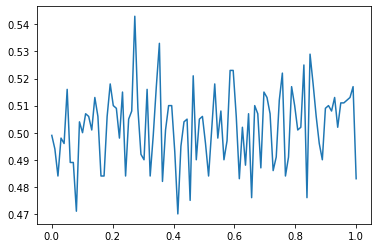

In [103]:
plt.plot(w_hat.cpu(), y)

In [ ]:
res=np.zeros(len(w_hat)-1)
for i in range(1,len(w_hat)):
    res[i-1] = simps(y[:i]-w_hat[:i].numpy(), w_hat[:i].numpy())
const = 1/res[-1]
p_m = np.exp(N*res)*const
potential = res + (1/N)*np.log(res[-1])
#plt.plot(w_hat[1:], potential)
plt.plot(w_hat[1:], res)
p_m;